In [1]:
!nvidia-smi

Thu Jun 24 01:16:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive')

%reload_ext tensorboard


Mounted at /content/gdrive


In [2]:
!pip install -U albumentations>=0.3.0 --user
!pip install --upgrade git+https://github.com/albumentations-team/albumentations


import albumentations as A

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-78ihauek
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-78ihauek
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=1177f6495d268e4285ed768191b304edff005cc2b95ab9b9b125f51074a92d7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xo32qxpg/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 1.0.0
    Uninstalling albumentations-1.0.0:
      Successfully uninstalled albumentations-1.0.0


In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# custom torch package
import torchkit
from torchkit.run import train, test, fit
from torchkit.data.dataloader import convert
from torchkit.data.dataset import CIFAR_Dataset
from torchkit.utils import data_utils, model_utils
from torchkit.models.cifar_net import SeaFar
from torchkit.torchsummary import summary

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [4]:
# Download CIFAR data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Train and Test Transforms 

train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4675, 0.4599, 0.4236), mask_fill_value = None),
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])


test_transform = A.Compose(
    [
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])

In [6]:
train = CIFAR_Dataset(trainset.data, trainset.targets, transforms=train_transform)
test = CIFAR_Dataset(testset.data, testset.targets, transforms=test_transform)

train_loader, test_loader = convert(train, test)


In [7]:
class GlobalConfig:
    seed = 1992
    num_classes = 10
    batch_size = 128
    EPOCHS = 70
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data
    input_image_size = (3, 32, 32)
    trainloader = train_loader
    testloader = test_loader

    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



    # model data normalization
    channel_norm = 'BatchNorm2d'
    channel_norm_params = {'GroupNorm': {'num_groups':2},
                 'BatchNorm2d':{'affine':True},
                 'LayerNorm': {'normalized_shape':10}}
                

    # regularizer
    dropout_value = 0.05

    # loss
    loss_function = 'CrossEntropyLoss'

    # scheduler
    lr_scheduler = 'StepLR'
    lr_scheduler_params = {'StepLR': {'step_size':7, 'gamma':0.5},
                
                'ReduceLROnPlateau': {'mode':'min', 'factor':0.5, 'patience':2, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-4,
                                      'eps':1e-08, 'verbose':True},
                'OneCycleLR': {'max_lr': 0.2, 'steps_per_epoch':len(trainloader), 'div_factor':20, 'epochs':EPOCHS }}
                                

    # optimizer
    optimizer = 'SGD'
    optimizer_params = {'SGD':{'lr':0.01, 'momentum':0.9}}

    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}

    # Params
    misclassified=True
    L1Lambda=False

    
modelconfig = GlobalConfig


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

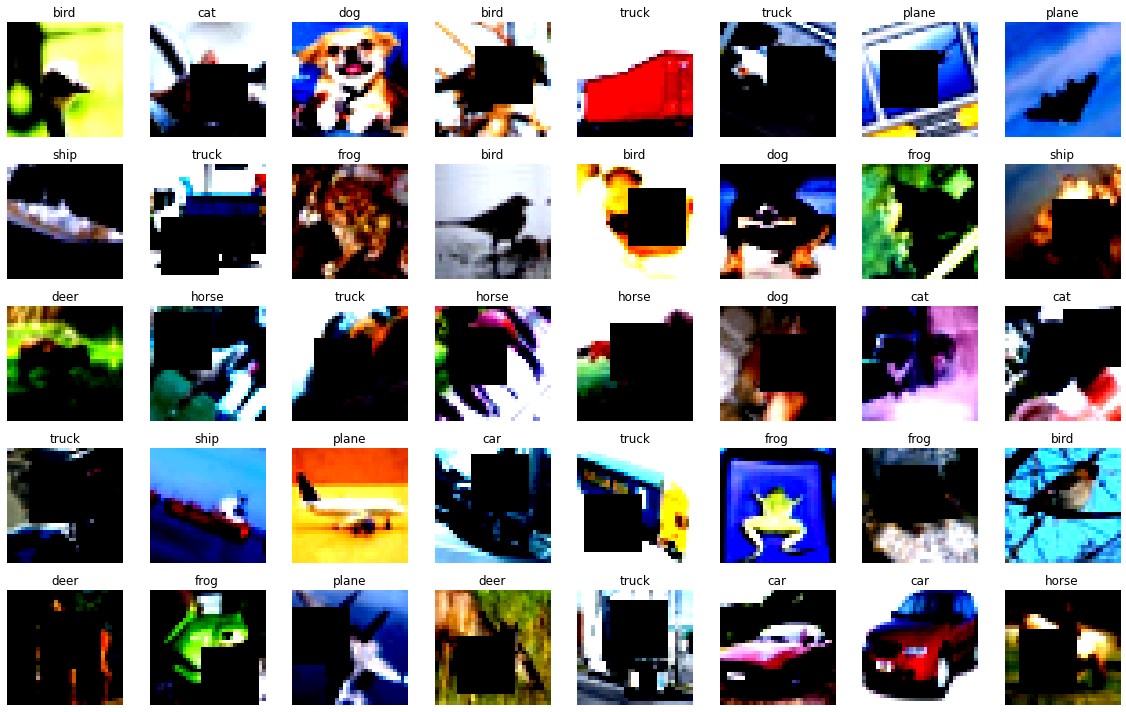

In [8]:
img, label = next(iter(modelconfig.trainloader))
data = CIFAR_Dataset(img,label)
data_utils.plot_data(data,modelconfig)

**Class/Batch Balance**

In [9]:
from collections import defaultdict
data = defaultdict()
for batch_idx, (images, labels) in enumerate(iter(modelconfig.trainloader)):
  data[batch_idx] = labels

total_data = []
first_batch = data[1]
for i in range(len(data)):
  for label in list(data[i]):
   total_data.append(label.item())

class_balance = defaultdict()
class_data = {0,1,2,3,4,5,6,7,8,9}
for i in class_data:
  class_balance[i]=total_data.count(i)
class_balance



defaultdict(None,
            {0: 5000,
             1: 5000,
             2: 5000,
             3: 5000,
             4: 5000,
             5: 5000,
             6: 5000,
             7: 5000,
             8: 5000,
             9: 5000})

All classes have same number of images, 5000. Dataset is balanced. 

In [18]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, config):
        super(Net, self).__init__()
        self.config = config
        ## Convolution Block1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias = False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(self.config.dropout_value),

            nn.Conv2d(32, 64, 3, padding=1, bias = False), # Input: 32x32x32 | Output: 32x32x64 | RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.config.dropout_value)
        )
        
        ## Transition Block1
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 32,3, stride=2), # Input: 32x32x64 | Output: 16x16x32 | RF: 5x5
            nn.ReLU(),
        )

        ## Convolution Block2
        self.conv2 =  nn.Sequential(
            nn.Conv2d(32, 64, 3,  padding=1,  dilation=2, bias = False), # Input: 16x16x32 | Output: 16x16x32 | RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.config.dropout_value),

            ## Depthwise Seperable Convolution1
            nn.Conv2d(64,32, 3,  padding=1,groups=32 ,bias = False),  # Input: 16x16x32 | Output: 16x16x32 | RF: 9x9
            nn.Conv2d(32, 64, 1, padding=1, bias = False),   # Input: 16x16x32 | Output: 18x18x64 | RF: 13x13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.config.dropout_value),
        )
        
        #Transition Block2
        self.trans2 = nn.Sequential(

            nn.Conv2d(64, 32, 3, stride=2), # Input: 18x18x32 | Output: 9x9x64 | RF: 17x17
            nn.ReLU()
        )

        #Convolution Block3
        self.conv3 = nn.Sequential(
            
            ## Dilation Block
            nn.Conv2d(32, 64, 3,  padding=1, bias = False), # Input: 9x9x64 | Output: 7x7x64 | RF: 33x33
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.config.dropout_value),

            nn.Conv2d(64, 64, 3,  padding=1, bias = False),  # Input: 7x7x64| Output: 7x7x64 | RF: 41x41
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(self.config.dropout_value),
        )

        #Transition Block3
        self.trans3 = nn.Sequential(

            nn.Conv2d(64, 16, 3, stride=2, padding=1), # Input: 7x7x64| Output: 4x4x16 | RF: 49x49
            nn.ReLU()
        )

        #Convolution Block4        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias = False), # Input: 4x4x16 | Output: 4x4x32 | RF: 65x65
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(self.config.dropout_value),

            ## Depthwise seperable Convolution2
            nn.Conv2d(32,32, 3,bias = False),# Input: 4x4x16 | Output: 4x4x32 | RF: 97x97
            nn.Conv2d(32, 10, 1,  bias = False),          # Input: 4x4x32| Output: 6x6x10 | RF: 97x97
            nn.ReLU(),
            nn.BatchNorm2d(10),
            # nn.Dropout2d(self.config.dropout_value),
        )

        ## Output Block
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) 


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)

        x = self.conv2(x) 
        x = self.trans2(x) 

        x = self.conv3(x) 
        x = self.trans3(x)

        x = self.conv4(x)
        x = self.gap(x)

        final_op = x.view(-1,10)
        if self.config.loss_function == 'CrossEntropyLoss':
            return final_op
        elif self.config.loss_function == 'NLLoss':
            return F.log_softmax(final_op, dim=-1)


In [20]:
# SeaFar
model = Net(modelconfig).to(modelconfig.device)
summary(model, input_size=modelconfig.input_image_size)
train_misc_img, test_misc_img, model_results = fit(model=model, config=modelconfig)

  0%|          | 0/391 [00:00<?, ?it/s]

------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape         Param #           Receptive Field
            Conv2d-1           [-1, 32, 32, 32]             864               3
              ReLU-2           [-1, 32, 32, 32]               0               3
       BatchNorm2d-3           [-1, 32, 32, 32]              64               3
         Dropout2d-4           [-1, 32, 32, 32]               0               3
            Conv2d-5           [-1, 64, 32, 32]          18,432               5
              ReLU-6           [-1, 64, 32, 32]               0               5
       BatchNorm2d-7           [-1, 64, 32, 32]             128               5
         Dropout2d-8           [-1, 64, 32, 32]               0               5
            Conv2d-9           [-1, 32, 15, 15]          18,464               7
             ReLU-10           [-1, 32, 15, 15]               0               7
           Co

Train set: batch_id=390  Average loss: 1.589617371559143 Accuracy: 33.628: 100%|██████████| 391/391 [00:12<00:00, 31.09it/s]


Validation loss has  decreased from inf to 0.0127. Saving the model


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 4238/10000 (42.38%)


EPOCH:  2 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.6660677194595337 Accuracy: 42.872: 100%|██████████| 391/391 [00:12<00:00, 30.79it/s]


Validation loss has  decreased from 0.0127 to 0.0104. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 5245/10000 (52.45%)


EPOCH:  3 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.2923132181167603 Accuracy: 47.334: 100%|██████████| 391/391 [00:12<00:00, 31.10it/s]


Validation loss has  decreased from 0.0104 to 0.0097. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 5598/10000 (55.98%)


EPOCH:  4 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.3777538537979126 Accuracy: 50.254: 100%|██████████| 391/391 [00:12<00:00, 31.37it/s]


Validation loss has  decreased from 0.0097 to 0.0088. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 6000/10000 (60.00%)


EPOCH:  5 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.3859065771102905 Accuracy: 52.638: 100%|██████████| 391/391 [00:12<00:00, 31.20it/s]


Validation loss has  decreased from 0.0088 to 0.0086. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6139/10000 (61.39%)


EPOCH:  6 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.2304232120513916 Accuracy: 54.742: 100%|██████████| 391/391 [00:12<00:00, 31.27it/s]


Validation loss has  decreased from 0.0086 to 0.0075. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6664/10000 (66.64%)


EPOCH:  7 LR:  [0.01]


Train set: batch_id=390  Average loss: 1.2219669818878174 Accuracy: 56.83: 100%|██████████| 391/391 [00:12<00:00, 30.78it/s]


Validation loss has  decreased from 0.0075 to 0.0075. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 6681/10000 (66.81%)


EPOCH:  8 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.2259564399719238 Accuracy: 58.126: 100%|██████████| 391/391 [00:12<00:00, 30.63it/s]


Validation loss has  decreased from 0.0075 to 0.007. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6858/10000 (68.58%)


EPOCH:  9 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.1496059894561768 Accuracy: 59.792: 100%|██████████| 391/391 [00:12<00:00, 30.73it/s]


Validation loss has  decreased from 0.007 to 0.0067. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7060/10000 (70.60%)


EPOCH:  10 LR:  [0.005]


Train set: batch_id=390  Average loss: 0.9258171916007996 Accuracy: 60.64: 100%|██████████| 391/391 [00:12<00:00, 30.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7007/10000 (70.07%)


EPOCH:  11 LR:  [0.005]


Train set: batch_id=390  Average loss: 0.8303737640380859 Accuracy: 61.656: 100%|██████████| 391/391 [00:12<00:00, 30.71it/s]


Validation loss has  decreased from 0.0067 to 0.0064. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7149/10000 (71.49%)


EPOCH:  12 LR:  [0.005]


Train set: batch_id=390  Average loss: 0.9998787045478821 Accuracy: 62.952: 100%|██████████| 391/391 [00:12<00:00, 30.93it/s]


Validation loss has  decreased from 0.0064 to 0.0062. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7304/10000 (73.04%)


EPOCH:  13 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.1049919128417969 Accuracy: 63.36: 100%|██████████| 391/391 [00:12<00:00, 30.95it/s]


Validation loss has  decreased from 0.0062 to 0.0059. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7425/10000 (74.25%)


EPOCH:  14 LR:  [0.005]


Train set: batch_id=390  Average loss: 1.363486886024475 Accuracy: 64.122: 100%|██████████| 391/391 [00:12<00:00, 30.73it/s]


Validation loss has  decreased from 0.0059 to 0.0058. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7456/10000 (74.56%)


EPOCH:  15 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.9132577776908875 Accuracy: 64.78: 100%|██████████| 391/391 [00:12<00:00, 30.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7455/10000 (74.55%)


EPOCH:  16 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.8210551142692566 Accuracy: 65.318: 100%|██████████| 391/391 [00:12<00:00, 30.74it/s]


Validation loss has  decreased from 0.0058 to 0.0056. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 7518/10000 (75.18%)


EPOCH:  17 LR:  [0.0025]


Train set: batch_id=390  Average loss: 1.1229993104934692 Accuracy: 65.908: 100%|██████████| 391/391 [00:12<00:00, 30.92it/s]


Validation loss has  decreased from 0.0056 to 0.0054. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7633/10000 (76.33%)


EPOCH:  18 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.8556771278381348 Accuracy: 66.366: 100%|██████████| 391/391 [00:12<00:00, 30.87it/s]


Validation loss has  decreased from 0.0054 to 0.0052. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7713/10000 (77.13%)


EPOCH:  19 LR:  [0.0025]


Train set: batch_id=390  Average loss: 1.049088954925537 Accuracy: 66.674: 100%|██████████| 391/391 [00:12<00:00, 30.74it/s]


Validation loss has  decreased from 0.0052 to 0.0052. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7755/10000 (77.55%)


EPOCH:  20 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.8946183919906616 Accuracy: 67.302: 100%|██████████| 391/391 [00:12<00:00, 30.84it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7743/10000 (77.43%)


EPOCH:  21 LR:  [0.0025]


Train set: batch_id=390  Average loss: 0.8669508099555969 Accuracy: 67.524: 100%|██████████| 391/391 [00:12<00:00, 30.89it/s]


Validation loss has  decreased from 0.0052 to 0.0051. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7787/10000 (77.87%)


EPOCH:  22 LR:  [0.00125]


Train set: batch_id=390  Average loss: 1.0007095336914062 Accuracy: 67.95: 100%|██████████| 391/391 [00:12<00:00, 30.26it/s]


Validation loss has  decreased from 0.0051 to 0.0048. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7929/10000 (79.29%)


EPOCH:  23 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.7522442936897278 Accuracy: 68.406: 100%|██████████| 391/391 [00:12<00:00, 30.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7867/10000 (78.67%)


EPOCH:  24 LR:  [0.00125]


Train set: batch_id=390  Average loss: 1.0222234725952148 Accuracy: 68.458: 100%|██████████| 391/391 [00:12<00:00, 30.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7861/10000 (78.61%)


EPOCH:  25 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.9276242256164551 Accuracy: 68.622: 100%|██████████| 391/391 [00:12<00:00, 30.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 7908/10000 (79.08%)


EPOCH:  26 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.91650390625 Accuracy: 68.988: 100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


Validation loss has  decreased from 0.0048 to 0.0048. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7943/10000 (79.43%)


EPOCH:  27 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.801131546497345 Accuracy: 69.102: 100%|██████████| 391/391 [00:12<00:00, 30.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7913/10000 (79.13%)


EPOCH:  28 LR:  [0.00125]


Train set: batch_id=390  Average loss: 0.9559471011161804 Accuracy: 69.544: 100%|██████████| 391/391 [00:12<00:00, 30.46it/s]


Validation loss has  decreased from 0.0048 to 0.0047. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7971/10000 (79.71%)


EPOCH:  29 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.9884878396987915 Accuracy: 69.956: 100%|██████████| 391/391 [00:12<00:00, 30.37it/s]


Validation loss has  decreased from 0.0047 to 0.0047. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7996/10000 (79.96%)


EPOCH:  30 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.9127971529960632 Accuracy: 69.902: 100%|██████████| 391/391 [00:12<00:00, 30.57it/s]


Validation loss has  decreased from 0.0047 to 0.0045. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8021/10000 (80.21%)


EPOCH:  31 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.9691556692123413 Accuracy: 70.288: 100%|██████████| 391/391 [00:13<00:00, 29.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7947/10000 (79.47%)


EPOCH:  32 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.8822166323661804 Accuracy: 70.366: 100%|██████████| 391/391 [00:12<00:00, 30.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8031/10000 (80.31%)


EPOCH:  33 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.7543746829032898 Accuracy: 70.734: 100%|██████████| 391/391 [00:12<00:00, 30.75it/s]


Validation loss has  decreased from 0.0045 to 0.0045. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8018/10000 (80.18%)


EPOCH:  34 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.7489748597145081 Accuracy: 70.506: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]


Validation loss has  decreased from 0.0045 to 0.0044. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8131/10000 (81.31%)


EPOCH:  35 LR:  [0.000625]


Train set: batch_id=390  Average loss: 0.8092877268791199 Accuracy: 70.86: 100%|██████████| 391/391 [00:12<00:00, 30.68it/s]


Validation loss has  decreased from 0.0044 to 0.0044. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8110/10000 (81.10%)


EPOCH:  36 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.96906977891922 Accuracy: 71.358: 100%|██████████| 391/391 [00:12<00:00, 30.32it/s]


Validation loss has  decreased from 0.0044 to 0.0044. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8119/10000 (81.19%)


EPOCH:  37 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.8708208203315735 Accuracy: 71.316: 100%|██████████| 391/391 [00:12<00:00, 30.60it/s]


Validation loss has  decreased from 0.0044 to 0.0043. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8097/10000 (80.97%)


EPOCH:  38 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.9780339002609253 Accuracy: 71.67: 100%|██████████| 391/391 [00:12<00:00, 30.35it/s]


Validation loss has  decreased from 0.0043 to 0.0043. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8164/10000 (81.64%)


EPOCH:  39 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.9839398264884949 Accuracy: 71.746: 100%|██████████| 391/391 [00:12<00:00, 30.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8139/10000 (81.39%)


EPOCH:  40 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.8815469741821289 Accuracy: 71.844: 100%|██████████| 391/391 [00:12<00:00, 30.47it/s]


Validation loss has  decreased from 0.0043 to 0.0043. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8164/10000 (81.64%)


EPOCH:  41 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.7178144454956055 Accuracy: 72.01: 100%|██████████| 391/391 [00:12<00:00, 30.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8119/10000 (81.19%)


EPOCH:  42 LR:  [0.0003125]


Train set: batch_id=390  Average loss: 0.8018490076065063 Accuracy: 72.258: 100%|██████████| 391/391 [00:12<00:00, 30.45it/s]


Validation loss has  decreased from 0.0043 to 0.0042. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8212/10000 (82.12%)


EPOCH:  43 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.9493788480758667 Accuracy: 72.208: 100%|██████████| 391/391 [00:12<00:00, 30.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8185/10000 (81.85%)


EPOCH:  44 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.6958773732185364 Accuracy: 72.298: 100%|██████████| 391/391 [00:12<00:00, 30.17it/s]


Validation loss has  decreased from 0.0042 to 0.0042. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8216/10000 (82.16%)


EPOCH:  45 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.9379026293754578 Accuracy: 72.38: 100%|██████████| 391/391 [00:12<00:00, 30.30it/s]


Validation loss has  decreased from 0.0042 to 0.0041. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8248/10000 (82.48%)


EPOCH:  46 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.6959205865859985 Accuracy: 72.918: 100%|██████████| 391/391 [00:12<00:00, 30.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8202/10000 (82.02%)


EPOCH:  47 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 1.07511568069458 Accuracy: 72.638: 100%|██████████| 391/391 [00:12<00:00, 30.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8209/10000 (82.09%)


EPOCH:  48 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.879957377910614 Accuracy: 72.892: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]


Validation loss has  decreased from 0.0041 to 0.0041. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8223/10000 (82.23%)


EPOCH:  49 LR:  [0.00015625]


Train set: batch_id=390  Average loss: 0.8396638631820679 Accuracy: 73.06: 100%|██████████| 391/391 [00:12<00:00, 30.70it/s]


Validation loss has  decreased from 0.0041 to 0.0041. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8250/10000 (82.50%)


EPOCH:  50 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.8589892387390137 Accuracy: 72.7: 100%|██████████| 391/391 [00:12<00:00, 30.64it/s]


Validation loss has  decreased from 0.0041 to 0.004. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8274/10000 (82.74%)


EPOCH:  51 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 1.017458438873291 Accuracy: 73.264: 100%|██████████| 391/391 [00:12<00:00, 30.63it/s]


Validation loss has  decreased from 0.004 to 0.004. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8287/10000 (82.87%)


EPOCH:  52 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.7234097719192505 Accuracy: 73.352: 100%|██████████| 391/391 [00:12<00:00, 30.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8233/10000 (82.33%)


EPOCH:  53 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 1.0417678356170654 Accuracy: 73.376: 100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


Validation loss has  decreased from 0.004 to 0.004. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8292/10000 (82.92%)


EPOCH:  54 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.9578129649162292 Accuracy: 73.558: 100%|██████████| 391/391 [00:13<00:00, 30.07it/s]


Validation loss has  decreased from 0.004 to 0.0039. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8295/10000 (82.95%)


EPOCH:  55 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.700115442276001 Accuracy: 73.592: 100%|██████████| 391/391 [00:12<00:00, 30.31it/s]


Validation loss has  decreased from 0.0039 to 0.0039. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8305/10000 (83.05%)


EPOCH:  56 LR:  [7.8125e-05]


Train set: batch_id=390  Average loss: 0.6001409292221069 Accuracy: 73.612: 100%|██████████| 391/391 [00:12<00:00, 30.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8267/10000 (82.67%)


EPOCH:  57 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.8683006167411804 Accuracy: 73.644: 100%|██████████| 391/391 [00:12<00:00, 30.78it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8277/10000 (82.77%)


EPOCH:  58 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.5412324070930481 Accuracy: 73.714: 100%|██████████| 391/391 [00:12<00:00, 30.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8298/10000 (82.98%)


EPOCH:  59 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.8807786107063293 Accuracy: 73.664: 100%|██████████| 391/391 [00:12<00:00, 30.60it/s]


Validation loss has  decreased from 0.0039 to 0.0039. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8333/10000 (83.33%)


EPOCH:  60 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.7663397789001465 Accuracy: 74.304: 100%|██████████| 391/391 [00:12<00:00, 30.70it/s]


Validation loss has  decreased from 0.0039 to 0.0039. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8352/10000 (83.52%)


EPOCH:  61 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.7869503498077393 Accuracy: 74.162: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s]


Validation loss has  decreased from 0.0039 to 0.0038. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8317/10000 (83.17%)


EPOCH:  62 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.950007438659668 Accuracy: 74.154: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]


Validation loss has  decreased from 0.0038 to 0.0038. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8379/10000 (83.79%)


EPOCH:  63 LR:  [3.90625e-05]


Train set: batch_id=390  Average loss: 0.7533799409866333 Accuracy: 74.25: 100%|██████████| 391/391 [00:12<00:00, 30.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8354/10000 (83.54%)


EPOCH:  64 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.5675966143608093 Accuracy: 74.058: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8336/10000 (83.36%)


EPOCH:  65 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.7059320211410522 Accuracy: 74.92: 100%|██████████| 391/391 [00:12<00:00, 30.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8351/10000 (83.51%)


EPOCH:  66 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.6495503187179565 Accuracy: 74.636: 100%|██████████| 391/391 [00:12<00:00, 30.62it/s]


Validation loss has  decreased from 0.0038 to 0.0037. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8402/10000 (84.02%)


EPOCH:  67 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.7548699378967285 Accuracy: 74.412: 100%|██████████| 391/391 [00:13<00:00, 29.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8386/10000 (83.86%)


EPOCH:  68 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.7932557463645935 Accuracy: 74.562: 100%|██████████| 391/391 [00:13<00:00, 30.00it/s]


Validation loss has  decreased from 0.0037 to 0.0037. Saving the model


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8407/10000 (84.07%)


EPOCH:  69 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.6979458332061768 Accuracy: 74.736: 100%|██████████| 391/391 [00:12<00:00, 30.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8385/10000 (83.85%)


EPOCH:  70 LR:  [1.953125e-05]


Train set: batch_id=390  Average loss: 0.6718971133232117 Accuracy: 74.812: 100%|██████████| 391/391 [00:12<00:00, 30.31it/s]



Test set: Average loss: 0.0037, Accuracy: 8386/10000 (83.86%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

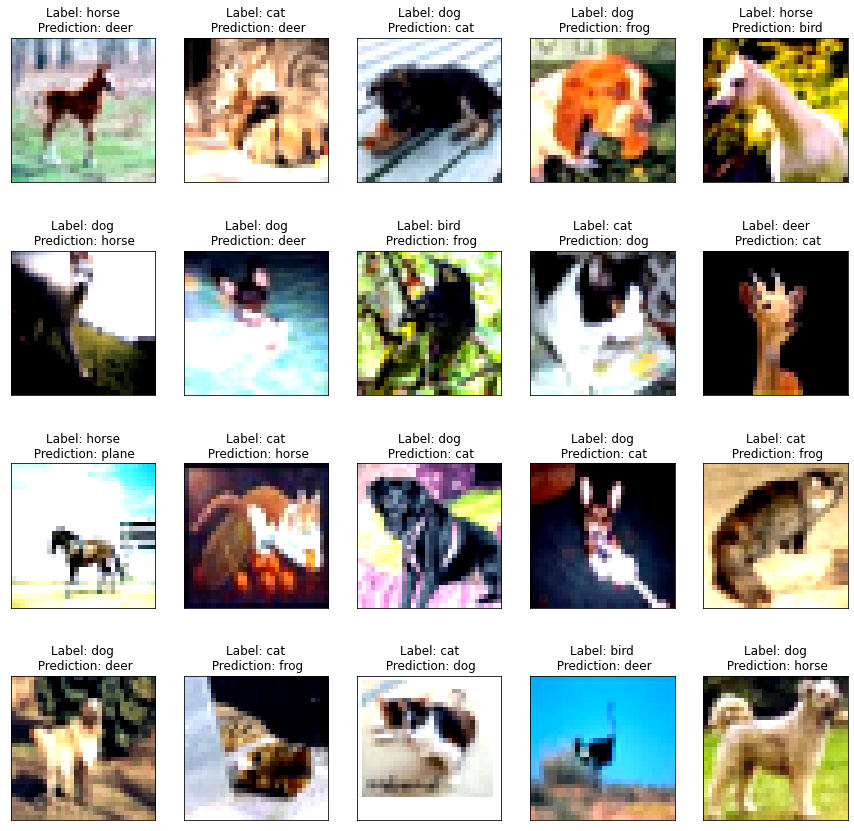

In [21]:
test_misc_images = [test_misc_img[i] for i in range(20)]
data_utils.plot_misclassified_rgb(test_misc_images, 'test_misc_batchnorm.png', config=modelconfig)

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in modelconfig.testloader:
        images, labels = data
        labels=labels.to(modelconfig.device)
        outputs = model(images.to(modelconfig.device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        modelconfig.classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 89 %
Accuracy of   car : 93 %
Accuracy of  bird : 78 %
Accuracy of   cat : 60 %
Accuracy of  deer : 73 %
Accuracy of   dog : 76 %
Accuracy of  frog : 94 %
Accuracy of horse : 97 %
Accuracy of  ship : 93 %
Accuracy of truck : 83 %


In [ ]:
len(modelconfig.testloader)

In [23]:
_results = modelconfig.model_results
testacc =  _results['TestAccuracy']
trainacc =  _results['TrainAccuracy']
testloss = [i/len(modelconfig.testloader) for i in _results['TestLoss']]
trainloss = [i/len(modelconfig.trainloader) for i in _results['TrainLoss']]

# testacc = model_results['TestAccuracy']
# trainacc = model_results['TrainAccuracy']
# testloss = model_results['TestLoss']
# trainloss = model_results['TrainLoss']
# _results

In [ ]:
len(testacc)

In [24]:
plot_details_dict = {'Test Accuracy(%)': 'Validation Accuracy',
                     'Train Accuracy(%)': 'Train Accuracy',
                     'Test Loss(%)': 'Validation Loss',
                     'Train Loss(%)': 'Train Loss'}


def plot_curve(data, y_label):
  # Plotting both the curves simultaneously
  with plt.style.context('dark_background'):# fivethirtyeight
    plt.plot(data[0:70], color='r', label='BatchNorm')
    
    # Naming the x-axis, y-axis and the whole graph
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.title(plot_details_dict[y_label])
      
    # Adding legend, which helps us recognize the curve according to it's color
    plt.legend()
  

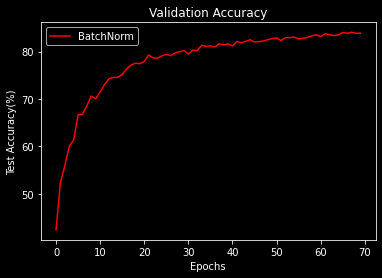

In [25]:
plot_curve(testacc, "Test Accuracy(%)")

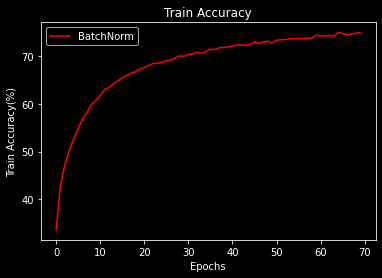

In [26]:
plot_curve(trainacc, "Train Accuracy(%)")

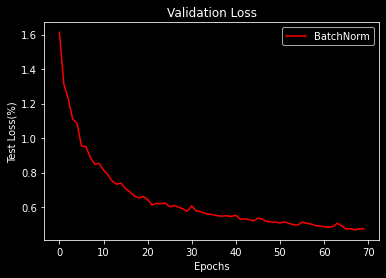

In [27]:
plot_curve(testloss, "Test Loss(%)")

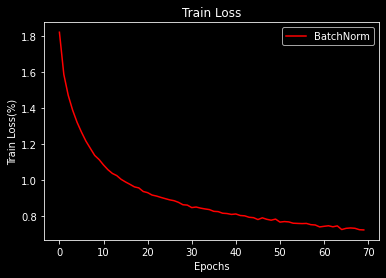

In [28]:
plot_curve(trainloss, "Train Loss(%)")